In [1]:
# Para conocer el enunciado del problema, consultar el libro:
# Metodos Numericos Aplicados a la Ingeniería: Casos de estudio utilizando MATLAB (2014)
# por Héctor Jorquera y Claudio Gelmi
# 
# Código Python escrito por Claudio Gelmi, Ph.D.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [3]:
# Lee datos experimentales
almidon_data = np.loadtxt('almidon.txt') # , delimiter=' ')
tiempo = almidon_data[:, 0]
almidon_exp = almidon_data[:, 1]

In [4]:
# Modelo diferencial
def css(t, x, params):
    # Parámetros
    yxs, ms = params
    mumax, kd, k, yxni, kn = 0.23, 0.025, 1.34e-4, 20.4, 7e-4
    # Ecuaciones diferenciales
    # Biomasa
    dx1 = mumax*x[2]/(kn + x[2])*x[0] - kd*x[0]
    # Úrea [2] y nitrógeno intermediario [3]
    if x[1] > 0:
        dx2 = -k
        dx3 = 0.47*k - mumax*x[2]/(kn + x[2])*x[0]/yxni
    else:
        dx2 = 0
        dx3 = 0 - mumax*x[2]/(kn + x[2])*x[0]/yxni
    # Almidón
    dx4 = -mumax*x[2]*x[0]/(kn + x[2])/yxs - ms*x[0]
    return [dx1, dx2, dx3, dx4]
    
# Rango de integración para todos los casos
t_span = (0, 150)

# Integramos el modelo diferencial para los mismos tiempos experimentales
def int_css(params,tiempo):
    X0 = [4.7e-3, 3.5e-3, 0, 0.18]
    sol = solve_ivp(css, t_span, X0, args=(params,), t_eval=tiempo)
    return sol.y[3]

In [5]:
# Optimización aleatoria (annealing method)
# Primera iteración
initial_guess = np.array([1.0, 0.5])
sum_error = np.sum((almidon_exp - int_css(initial_guess,tiempo))**2)

# Hyperparámetros del algoritmo
a, b = -0.025, 0.025
n_iter = 1000
param = initial_guess
ferror = []

# Algoritmo de búsqueda aleatoria
for i in range(n_iter):
    ferror.append(sum_error)
    x = a + (b - a)*np.random.rand(2)
    # Apply the parameters and compute the new error
    p1 = (1 + x)*param
    sum_error_1 = np.sum((almidon_exp - int_css(p1,tiempo))**2)
    # Update the parameters if the error decreases
    if sum_error_1 < sum_error:
        param = p1
        sum_error = sum_error_1
        
print('Parámetros encontrados:')
print('  yxs:', round(param[0], 2))
print('  ms:', round(param[1], 3))
print(f'- El error es (resnorm): {round(sum_error,4)}')

Parámetros encontrados:
  yxs: 1.99
  ms: 0.104
- El error es (resnorm): 0.0243


<Figure size 640x480 with 0 Axes>

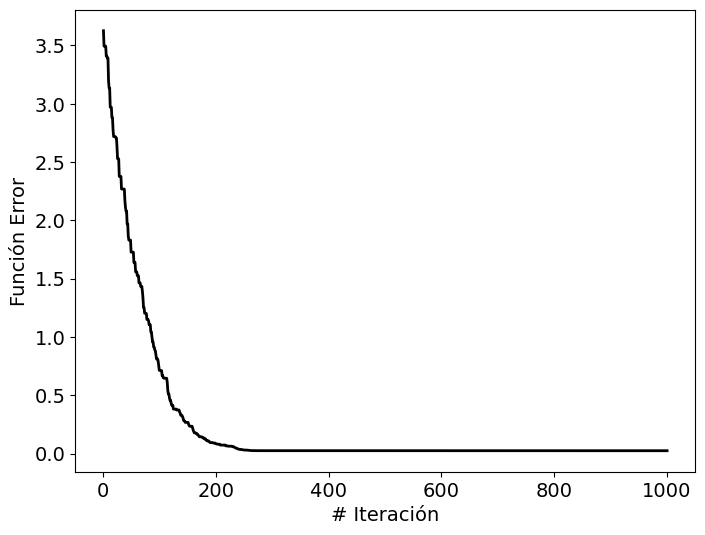

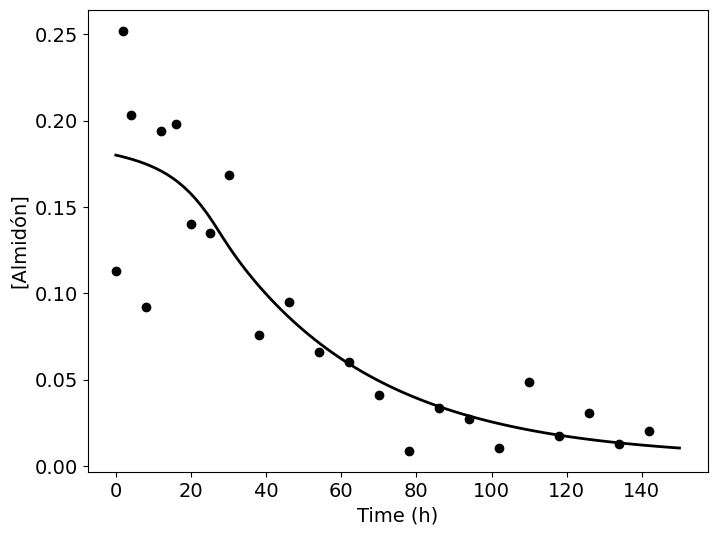

In [6]:
# Graficamos los resultados

plt.figure(1)
plt.figure(figsize=(8,6))
plt.plot(range(1, n_iter+1), ferror, 'k', lw=2)
plt.xlabel('# Iteración', fontsize=14)
plt.ylabel('Función Error', fontsize=14)
plt.tick_params(axis='both', labelsize=14)

# Integramos el modelo con los valores óptimos encontrados
X0 = [4.7e-3, 3.5e-3, 0, 0.18]
t_sim = np.linspace(0, 150, 100)
almidon_sim = solve_ivp(css, t_span, X0, args=(param,), t_eval=t_sim).y[3]

plt.figure(2)
plt.figure(figsize=(8,6))
plt.plot(tiempo, almidon_exp, 'ko')
plt.plot(t_sim, almidon_sim, 'k-', linewidth=2)
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('[Almidón]', fontsize=14)
plt.tick_params(axis='both', labelsize=14)

plt.show()